In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
EP7 = pd.read_csv("/content/drive/MyDrive/ Thesis 2023/EP7_total3.csv")

In [ ]:
import numpy as np

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/lsa_comps7th.pickle', 'rb') as f:
    lsa_comps = pickle.load(f)

In [ ]:
EP7["raw_text"].isna().sum() #quitar las instancias que no tienen texto


0

In [ ]:
EP7 = EP7.drop(["Unnamed: 0"],axis=1)

In [ ]:
EP7["raw_text"].isna().sum() #quitar las instancias que no tienen texto


0

In [ ]:
print(EP7["Type of Vote"].isna().sum())
print(EP7["Policy_area"].isna().sum())
print(EP7["Title"].isna().sum())

0
0
0


In [ ]:
# Fill NaN values with empty strings
EP7.fillna('', inplace=True)


In [ ]:
EP7.shape

(1662, 858)

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.6 MB/s eta 0:00:00


In [ ]:
lsa_comps.shape

(1662, 20)

In [ ]:

lsa_comps = lsa_comps.astype(np.int64)

In [ ]:
column_types = EP7.dtypes
print(column_types)

Vote ID          int64
raw_text        object
Type of Vote    object
Title           object
Policy_area     object
                 ...  
849              int64
850              int64
851              int64
852              int64
853              int64
Length: 858, dtype: object


In [ ]:
EP7.columns

Index(['Vote ID', 'raw_text', 'Type of Vote', 'Title', 'Policy_area', '1', '2',
       '3', '4', '5',
       ...
       '844', '845', '846', '847', '848', '849', '850', '851', '852', '853'],
      dtype='object', length=858)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import RandomOverSampler

f1_scores = []
roc_aucs = []
auprc_scores = []
recall_scores = []
precision_scores = []
predictions_list = []
true_labels_list = []
accuracy = []
shap_importances_dict = {}
X_test_dict = {}
accuracy_results = {}
accuracy_results_original = {}
counter = 1
newtruelist = []
newpredlist = []
roc_list = []
accuracy_results_old = {}

# Loop through each MEP column and train a separate model for each MEP
for col in EP7.columns[5:]:
    # Step 1: Prepare the data
    X = lsa_comps  # Input features (TF-IDF + truncated SVD features)
    y = EP7[col].values  # Target variable (voting behavior of the MEP)
    MEP_ID = col
    print(counter)
    counter += 1
    # Check the number of unique classes in the target variable
    num_classes = len(np.unique(y))
    if num_classes < 2:
        print(f"Skipping MEP {col} due to only one class present.")
        continue

    # Step 2: Split the data into training and testing sets
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
    model = Pipeline([
        ('scaler', StandardScaler()),  # You can apply additional preprocessing steps as needed
        ('classifier', RandomForestClassifier())  # Change the classifier as needed (e.g., DecisionTreeClassifier, RandomForestClassifier, SVC, MLPClassifier)
    ])

    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)

   # Step 4: Train the model and compute metrics
    accuracy_scores2 = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    accuracy_results_original[col] = {'accuracy': np.mean(accuracy_scores2)}
# Train and predict with the model for each fold
# Train and predict with the model for each fold
    for train_index, test_index in cv.split(X_ros, y_ros):
        try:
            X_train, X_test = X_ros[train_index], X_ros[test_index]
            y_train, y_test = y_ros[train_index], y_ros[test_index]
            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))
            whichprediction = np.unique(y_test)
            newpredlist = np.concatenate([newpredlist, whichprediction[np.argmax(predictions, axis=1)]])
            newtruelist = np.concatenate([newtruelist, y_test])
            for item in predictions:
              roc_list.append(item)
        except IndexError:
            print("Index out of bounds. Skipping this iteration.")
            continue
    whichprediction = np.unique(y_test)
    # Calculate evaluation metrics
    try:
      f1 = f1_score(y_test, whichprediction[np.argmax(predictions, axis=1)], average='weighted')
    except IndexError:
      continue
    #f12 = f1_score(y_test, np.argmax(predictions, axis=1), average='weighted')
    #roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y)), predictions, multi_class='ovr')
    precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1], pos_label=1)
    auprc = auc(recall, precision)
    recall = recall_score(y_test, whichprediction[np.argmax(predictions, axis=1)], average='weighted')
    precision = precision_score(y_test, whichprediction[np.argmax(predictions, axis=1)], average='weighted')
    accuracy = accuracy_score(y_test, whichprediction[np.argmax(predictions, axis=1)])
    #accuracy_3 = accuracy_score(y_test,np.argmax(predictions, axis=1))

    max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
    predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
    predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
    true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
    roc_auc = roc_auc_score(label_binarize(true_labels_array, classes=np.unique(true_labels_array)), predictions_array, multi_class='ovr')
    # Store the metrics in corresponding lists
    f1_scores.append(f1)
    #f1_scores2.append(f12)
    roc_aucs.append(roc_auc)
    auprc_scores.append(auprc)
    recall_scores.append(recall)
    precision_scores.append(precision)
    #accuracy2.append(accuracy_2)
    #accuracy3.append(accuracy_3)
    # Compute SHAP feature importances
    accuracy_results[col] = {'accuracy': accuracy}
    explainer = shap.TreeExplainer(model.named_steps['classifier'])
    shap_values = explainer.shap_values(X_test)
    importances = np.abs(shap_values).mean(axis=0)

    # Store SHAP importances and X_test in dictionaries
    shap_importances_dict[MEP_ID] = importances
    X_test_dict[MEP_ID] = X_test

    # Increment counter


# Convert the accuracy_results dictionary to a DataFrame
accuracy_df = pd.DataFrame.from_dict(accuracy_results, orient='index')
accuracy_df_original = pd.DataFrame.from_dict(accuracy_results_original, orient='index')
# Add the MEP column to the DataFrame
accuracy_df = accuracy_df.reset_index().rename(columns={'index': 'MEP'})
accuracy_df_original = accuracy_df_original.reset_index().rename(columns={'index': 'MEP'})



In [ ]:
print("done")

done


In [ ]:
accuracy_df.describe()

,accuracy
count,851.000000
mean,0.289376
std,0.034386
min,0.213898
25%,0.268405
50%,0.284706
75%,0.305522
max,0.517158


In [ ]:
accuracy_df_original.describe()

,accuracy
count,851.000000
mean,0.687971
std,0.145331
min,0.294232
25%,0.573707
50%,0.716006
75%,0.806860
max,0.990975


In [ ]:
precision_scores_df = pd.DataFrame(precision_scores, columns=["precision"])

# Apply describe function to the data frames
precision_scores_stats = precision_scores_df.describe()


# Print the statistics
print("precision Statistics:")
print(precision_scores_stats)


precision Statistics:
        precision
count  851.000000
mean     0.478383
std      0.099601
min      0.199823
25%      0.407765
50%      0.482860
75%      0.553054
max      0.722509


In [ ]:
# Convert lists to data frames
f1_scores_df = pd.DataFrame(f1_scores, columns=['F1 Score'])
roc_aucs_df = pd.DataFrame(roc_aucs, columns=['ROC AUC'])
# Apply describe function to the data frames
f1_scores_stats = f1_scores_df.describe()
roc_aucs_stats = roc_aucs_df.describe()

# Print the statistics
print("F1 Score Statistics:")
print(f1_scores_stats)
print("\nROC AUC Statistics:")
print(roc_aucs_stats)

F1 Score Statistics:
         F1 Score
count  851.000000
mean     0.228390
std      0.042034
min      0.141952
25%      0.200028
50%      0.221051
75%      0.251112
max      0.486064

ROC AUC Statistics:
          ROC AUC
count  851.000000
mean     0.485233
std      0.009853
min      0.477301
25%      0.480314
50%      0.481672
75%      0.486527
max      0.598513


In [ ]:
auprc_scores_df = pd.DataFrame(auprc_scores, columns=["auprc"])
recall_scores_df = pd.DataFrame(recall_scores, columns=["recall"])


# Apply describe function to the data frames
auprc_scores_stats = auprc_scores_df.describe()
recall_stats = recall_scores_df.describe()
# Print the statistics
print("AUPRC Statistics:")
print(auprc_scores_stats)
print("recall Statistics:")
print(recall_stats)

AUPRC Statistics:
            auprc
count  851.000000
mean     0.244073
std      0.082476
min      0.109803
25%      0.188201
50%      0.234599
75%      0.285134
max      0.685469
recall Statistics:
           recall
count  851.000000
mean     0.289376
std      0.034386
min      0.213898
25%      0.268405
50%      0.284706
75%      0.305522
max      0.517158


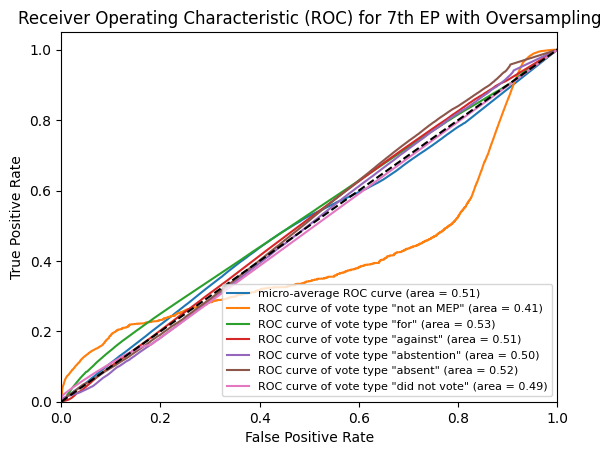

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
#aggregate_predictions = newpredlist
#aggregate_true_labels = newtruelist

# Define custom class names
class_names = ["not an MEP", "for", "against", "abstention", "absent","did not vote"]  # Add class names accordingly

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)
whichprediction = np.unique(y_test)
for i in range(num_classes):
  fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i], aggregate_predictions[:, i])
  #fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)), aggregate_predictions)
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(), aggregate_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of vote type "{0}" (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for 7th EP with Oversampling')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()


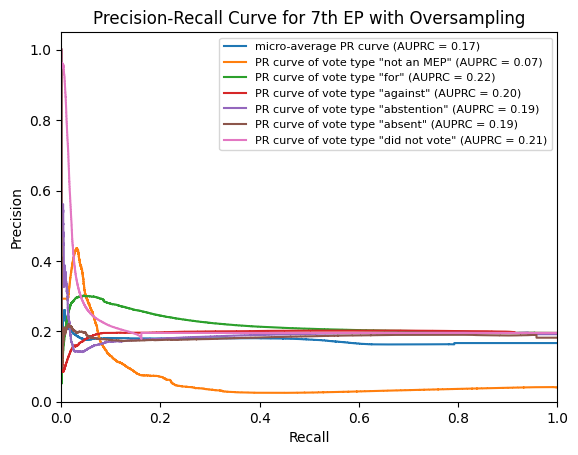

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
# aggregate_predictions = newpredlist
# aggregate_true_labels = newtruelist

# Define custom class names
class_names = ["not an MEP", "for", "against", "abstention", "absent", "did not vote"]  # Add class names accordingly

# Compute precision-recall curve and AUPRC for each class
precision = dict()
recall = dict()
average_precision = dict()

num_classes = len(class_names)
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i],
        aggregate_predictions[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Compute micro-average precision-recall curve and AUPRC
precision["micro"], recall["micro"], _ = precision_recall_curve(
    label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(),
    aggregate_predictions.ravel())
average_precision["micro"] = auc(recall["micro"], precision["micro"])

# Plot AUPRC curve
plt.figure()
plt.step(recall["micro"], precision["micro"], where='post', label='micro-average PR curve (AUPRC = {0:0.2f})'.format(
    average_precision["micro"]))
for i in range(num_classes):
    plt.step(recall[i], precision[i], where='post',
             label='PR curve of vote type "{0}" (AUPRC = {1:0.2f})'.format(class_names[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for 7th EP with Oversampling')
plt.legend(loc="upper right", prop={'size': 8})
plt.show()


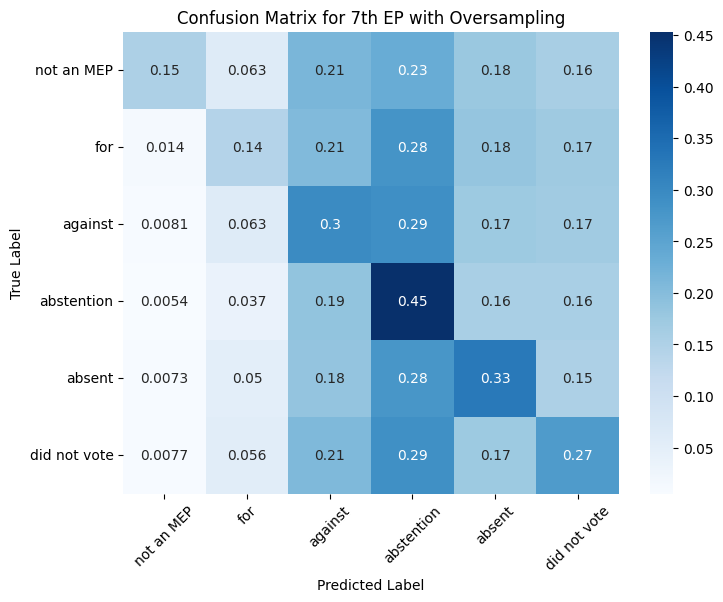

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert aggregate predictions and true labels to NumPy arrays
#aggregate_predictions = predictions_array
#aggregate_true_labels = true_labels_array
whichprediction = np.unique(y_test)
aggregate_predictions = newpredlist
aggregate_true_labels = newtruelist
# Define custom class names
class_names = ["not an MEP", "for", "against", "abstention", "absent","did not vote"]  # Add class names accordingly
# Compute confusion matrix
#cm = confusion_matrix(aggregate_true_labels, whichprediction[np.argmax(aggregate_predictions, axis=1)])
cm = confusion_matrix(aggregate_true_labels,(aggregate_predictions))
# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues")

# Set custom class names as tick labels
tick_labels = [class_names[i] for i in range(len(class_names))]
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=tick_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=tick_labels, rotation=0)

plt.title("Confusion Matrix for 7th EP with Oversampling")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
import pickle
# Save the list
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/f1_scores7th-overs.pkl', 'wb') as f:
    pickle.dump(f1_scores, f)
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/roc_aucs7th-overs.pkl', 'wb') as f:
    pickle.dump(roc_aucs, f)
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/auprc_scores7th-overs.pkl', 'wb') as f:
    pickle.dump(auprc_scores, f)
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/precision_scores7th-overs.pkl', 'wb') as f:
    pickle.dump(precision_scores, f)
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/predictions_list7th-overs.pkl', 'wb') as f:
    pickle.dump(predictions_list , f)
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/true_labels_list7th-overs.pkl', 'wb') as f:
    pickle.dump(true_labels_list , f)


In [ ]:
# Save the dictionary
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/shap_importances_dict7th-overs.pkl', 'wb') as f:
    pickle.dump(shap_importances_dict, f)
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/X_test_dict7th-overs.pkl', 'wb') as f:
    pickle.dump(X_test_dict, f)

In [ ]:
np.save('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/predictions_7th-overs.npy', predictions_array)

In [ ]:
np.save('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/truelabels_7th-overs.npy', true_labels_array)

In [ ]:
np.save('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/predlist_7th-overs.npy', newpredlist)

In [ ]:
np.save('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/truelist_7th-overs.npy', newtruelist)

In [ ]:
path = '/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/EP7_accs_orig-overs.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
 accuracy_df_original.to_csv(f)

In [ ]:
path = '/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/EP7_accs-overs.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
 accuracy_df.to_csv(f)